In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from Model.RoboNet import RoboNet
from Utilities.RoboNetUtilities import utils
from torch.utils.data import random_split
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
    
print("Device: ", device)
    

Device:  mps


In [3]:
image_input, move_inputs_y, arm_input = utils().load_data()

In [4]:
print(image_input.dtype,",",image_input.shape)
print(move_inputs_y.dtype,",",move_inputs_y.shape)
print(arm_input.dtype,",",arm_input.shape)

torch.float32 , torch.Size([4484, 3, 480, 480])
torch.int64 , torch.Size([4484])
torch.float64 , torch.Size([4484, 4])


Index:  1181
Move:  tensor(7)


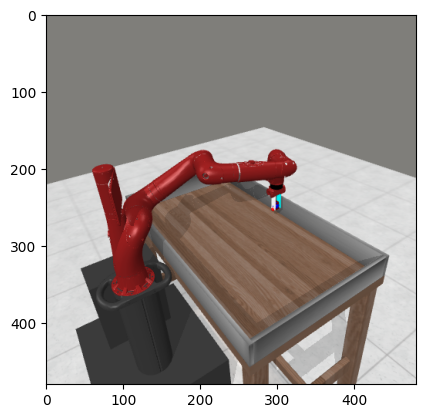

In [4]:
utils().display_data(move_inputs_y, image_input)

In [5]:
torch.unique(move_inputs_y, return_counts=True)

(tensor([1, 2, 3, 4, 5, 6, 7]),
 tensor([ 221,   21,  245,  379,  374,  266, 2978]))

In [6]:
dataset = torch.utils.data.TensorDataset(image_input, arm_input, move_inputs_y)


train_indices, test_val_indices = train_test_split(
    range(len(move_inputs_y)), test_size=0.2, stratify=move_inputs_y, random_state=42
)

val_indices, test_indices = train_test_split(
    test_val_indices, test_size=0.5, stratify=move_inputs_y[test_val_indices], random_state=42
)

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=32, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [7]:
len(valloader)

14

In [8]:
rn = RoboNet(8).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(rn.parameters(), lr=0.01, momentum=0.9)

weights = torch.load('SmallModel25.pth')
rn.load_state_dict(weights)

/Users/michael/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<All keys matched successfully>

In [9]:
# Training 

for epoch in range(26, 31):

  rn.train()
  batch = 1
  loss_val = 0.0
  correctTrain = 0
  totalTrain = 0
  total_batches = len(trainloader)
  for xbatch, armbatch ,ybatch in trainloader:
    xbatch = xbatch / 255.0
    xbatch = xbatch.to(device)
    armbatch = armbatch.to(torch.float32).to(device)
    ybatch = ybatch.to(device)
    
    optimizer.zero_grad()
    outputs = rn(xbatch, armbatch, batch)
    loss = criterion(outputs, ybatch.reshape(-1))
      
    loss.backward()
    optimizer.step()
    loss_val += loss.item()
    
    _, predicted = torch.max(outputs, 1)
    totalTrain += ybatch.size(0)
    correctTrain += (predicted == ybatch).sum().item()
    trainAcc = 100 * correctTrain / totalTrain
    batch +=1

  print(f"Epoch: {epoch}, Train Loss: {loss_val:.2f}, Train Accuracy: {trainAcc:.2f}")
  
  rn.eval()  
  val_loss = 0.0
  correct = 0
  total = 0
  with torch.no_grad(): 
      for xbatch, armbatch ,ybatch in valloader:
        xbatch = xbatch / 255.0
        xbatch = xbatch.to(device)
        armbatch = armbatch.to(torch.float32).to(device)
        ybatch = ybatch.to(device)

        outputs = rn(xbatch, armbatch, 1) 
        loss = criterion(outputs, ybatch)  
        val_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += ybatch.size(0)
        correct += (predicted == ybatch).sum().item()

  val_loss /= len(valloader)
  val_accuracy = 100 * correct / total
  print(f"Epoch: {epoch}, Val Loss: {val_loss:.2f}, Val Accuracy: {val_accuracy:.2f}%")
  
torch.save(rn.state_dict(), 'SmallModel30.pth')

Epoch: 26, Train Loss: 33.28, Train Accuracy: 89.85
Epoch: 26, Val Loss: 0.39, Val Accuracy: 88.62%
Epoch: 27, Train Loss: 33.39, Train Accuracy: 89.57
Epoch: 27, Val Loss: 0.37, Val Accuracy: 88.62%
Epoch: 28, Train Loss: 31.57, Train Accuracy: 90.30
Epoch: 28, Val Loss: 0.37, Val Accuracy: 88.84%
Epoch: 29, Train Loss: 31.43, Train Accuracy: 90.30
Epoch: 29, Val Loss: 0.35, Val Accuracy: 89.06%
Epoch: 30, Train Loss: 31.58, Train Accuracy: 90.16
Epoch: 30, Val Loss: 0.35, Val Accuracy: 88.39%


In [10]:
# Testing

rn.eval()
test_loss = 0.0
correct_predictions = 0
criterion = torch.nn.CrossEntropyLoss()

with torch.no_grad():
    for batch in testloader:
        
        image_input, arm_input, move_inputs_y = batch
        image_input = image_input / 255.0
        image_input = image_input.to(device)
        arm_input = arm_input.to(torch.float32).to(device)
        move_inputs_y = move_inputs_y.to(device)

        
        outputs = rn(image_input, arm_input,1)
        loss = criterion(outputs, move_inputs_y)
        
        test_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == move_inputs_y).sum().item()

average_loss = test_loss / len(testloader)
accuracy = correct_predictions / len(test_dataset) * 100

print(f"Test Loss: {average_loss:.4f}")
print(f"Test Accuracy: {accuracy:.2f}%")

Test Loss: 0.2626
Test Accuracy: 90.87%
